LSTM Stock prediction

By Joshua Jenkins

In [32]:
#Read stock CSV file
import pandas as pd
df = pd.read_csv('MSFT_Complete.csv')
df.head()

Date      Open      High       Low     Close  Adj Close      Volume
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.060396  1031788800
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062553   308160000
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063632   133171200
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.062014    67766400
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060936    47894400

In [33]:
df = df[['Date', 'Close']]

In [34]:
#Change format of date from string to datetime
import datetime
def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9455   2023-09-19
9456   2023-09-20
9457   2023-09-21
9458   2023-09-22
9459   2023-09-25
Name: Date, Length: 9460, dtype: datetime64[ns]

In [35]:
#Date now index
df.index = df.pop('Date')
df

Close
Date                  
1986-03-13    0.097222
1986-03-14    0.100694
1986-03-17    0.102431
1986-03-18    0.099826
1986-03-19    0.098090
...                ...
2023-09-19  328.649994
2023-09-20  320.769989
2023-09-21  319.529999
2023-09-22  317.010010
2023-09-25  317.540009

[9460 rows x 1 columns]

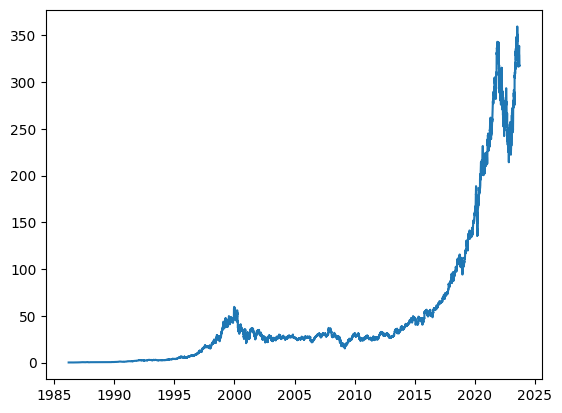

In [36]:
#Initial plot of the data
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [37]:
import numpy as np
#Changes dataframe to include the closing value of the 3 dates before the target date
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target Date-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '1986-09-25',
                                '2023-09-25',
                                n=3)
windowed_df

Target Date  Target Date-3  Target Date-2  Target Date-1      Target
0     1986-09-25       0.102431       0.104167       0.102865    0.100694
1     1986-09-26       0.104167       0.102865       0.100694    0.100694
2     1986-09-29       0.102865       0.100694       0.100694    0.098090
3     1986-09-30       0.100694       0.100694       0.098090    0.098090
4     1986-10-01       0.100694       0.098090       0.098090    0.097222
...          ...            ...            ...            ...         ...
9319  2023-09-19     338.700012     330.220001     329.059998  328.649994
9320  2023-09-20     330.220001     329.059998     328.649994  320.769989
9321  2023-09-21     329.059998     328.649994     320.769989  319.529999
9322  2023-09-22     328.649994     320.769989     319.529999  317.010010
9323  2023-09-25     320.769989     319.529999     317.010010  317.540009

[9324 rows x 5 columns]

In [38]:
#Sets data up into dates X and Y values
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    temp_matrix = df_as_np[:, 1:-1]
    X = temp_matrix.reshape((len(dates), temp_matrix.shape[1], 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((9324,), (9324, 3, 1), (9324,))

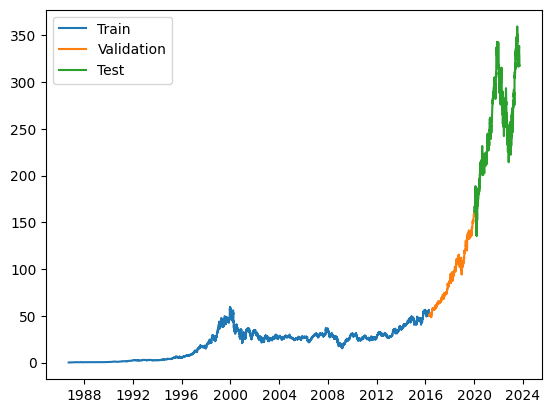

In [39]:
#Separating data into training, validation, and testing
q_80 = int(len(X) * 0.8)
q_90 = int(len(X) * 0.9)


dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [40]:
#Creating the LSTM model
from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss = 'mse',
              optimizer=Adam(learning_rate=0.001),
              metrics = ['mae'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)
                    

Epoch 1/100
234/234 [==============================] - 3s 4ms/step - loss: 140.3214 - mae: 5.5794 - val_loss: 2595.2722 - val_mae: 40.5799
Epoch 2/100
234/234 [==============================] - 1s 2ms/step - loss: 0.3934 - mae: 0.3657 - val_loss: 2315.5908 - val_mae: 37.3736
Epoch 3/100
234/234 [==============================] - 1s 2ms/step - loss: 0.3435 - mae: 0.3413 - val_loss: 2217.7571 - val_mae: 36.1680
Epoch 4/100
234/234 [==============================] - 1s 3ms/step - loss: 0.3394 - mae: 0.3424 - val_loss: 2179.0613 - val_mae: 35.8427
Epoch 5/100
234/234 [==============================] - 1s 2ms/step - loss: 0.3498 - mae: 0.3499 - val_loss: 2165.3037 - val_mae: 35.5935
Epoch 6/100
234/234 [==============================] - 1s 2ms/step - loss: 0.3321 - mae: 0.3396 - val_loss: 2153.1143 - val_mae: 35.4462
Epoch 7/100
234/234 [==============================] - 1s 2ms/step - loss: 0.3434 - mae: 0.3527 - val_loss: 2128.5195 - val_mae: 35.1285
Epoch 8/100
234/234 [==================

234/234 [==============================] - 1s 1ms/step


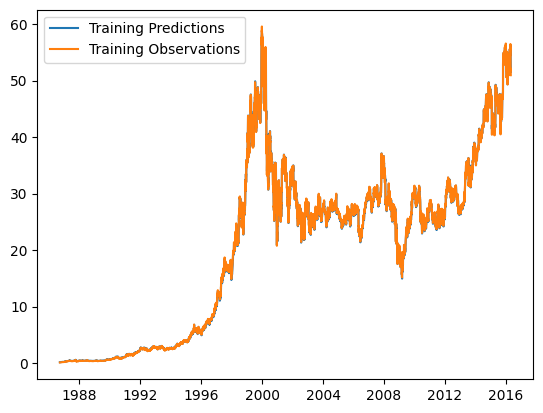

In [41]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

30/30 [==============================] - 0s 1ms/step


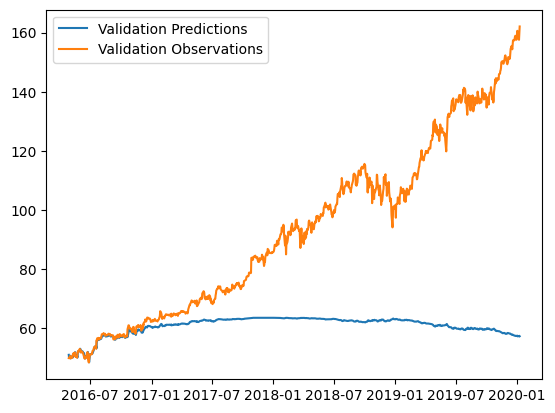

In [42]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

30/30 [==============================] - 0s 1ms/step


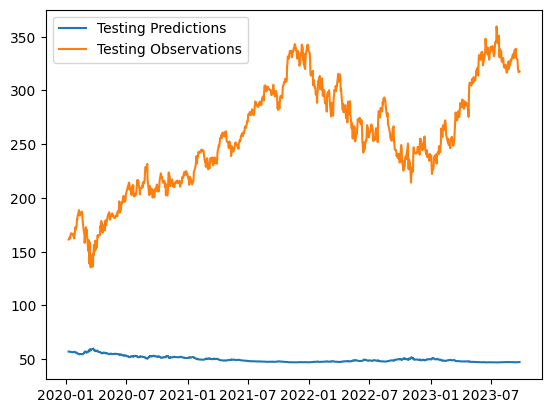

In [43]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [44]:
from copy import deepcopy

recursive_predictions = []
recursive_dates=np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    next_prediction=model.predict(np.array([last_window[-3:]])).flatten()
    recursive_predictions.append(next_prediction)
    last_window=np.concatenate((last_window,[next_prediction]))
    print(last_window)

print(recursive_predictions)

1/1 [==============================] - 0s 15ms/step
[[51.78  ]
 [52.11  ]
 [51.44  ]
 [51.5224]]
1/1 [==============================] - 0s 15ms/step
[[51.78  ]
 [52.11  ]
 [51.44  ]
 [51.5224]
 [51.6121]]
1/1 [==============================] - 0s 15ms/step
[[51.78   ]
 [52.11   ]
 [51.44   ]
 [51.5224 ]
 [51.6121 ]
 [51.69904]]
1/1 [==============================] - 0s 15ms/step
[[51.78    ]
 [52.11    ]
 [51.44    ]
 [51.5224  ]
 [51.6121  ]
 [51.69904 ]
 [51.786594]]
1/1 [==============================] - 0s 15ms/step
[[51.78    ]
 [52.11    ]
 [51.44    ]
 [51.5224  ]
 [51.6121  ]
 [51.69904 ]
 [51.786594]
 [51.874767]]
1/1 [==============================] - 0s 16ms/step
[[51.78    ]
 [52.11    ]
 [51.44    ]
 [51.5224  ]
 [51.6121  ]
 [51.69904 ]
 [51.786594]
 [51.874767]
 [51.96348 ]]
1/1 [==============================] - 0s 16ms/step
[[51.78    ]
 [52.11    ]
 [51.44    ]
 [51.5224  ]
 [51.6121  ]
 [51.69904 ]
 [51.786594]
 [51.874767]
 [51.96348 ]
 [52.05266 ]]
1/1 [===========

KeyboardInterrupt: 

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])